In [6]:
import pandas as pd
from scipy import signal
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

In [7]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/analysis.py

class CCAAnalysis:
    """Canonical Correlation Analysis for SSVEP paradigm"""
    def __init__(self, freqs, win_len, s_rate, n_harmonics=1):
        """
        Args:
            freqs (list): List of target frequencies
            win_len (float): Window length
            s_rate (int): Sampling rate of EEG signal
            n_harmonics (int): Number of harmonics to be considered
        """
        self.freqs = freqs
        self.win_len = win_len
        self.s_rate = s_rate
        self.n_harmonics = n_harmonics
        self.train_data = self._init_train_data()
        self.cca = CCA(n_components=1)

    def _init_train_data(self):
        t_vec = np.linspace(0, self.win_len, int(self.s_rate * self.win_len))
        targets = {}
        for freq in self.freqs:
            sig_sin, sig_cos = [], []
            for harmonics in range(self.n_harmonics):
                sig_sin.append(np.sin(2 * np.pi * harmonics * freq * t_vec))
                sig_cos.append(np.cos(2 * np.pi * harmonics * freq * t_vec))
            targets[freq] = np.array(sig_sin + sig_cos).T
        return targets

    def apply_cca(self, eeg):
        """Apply CCA analysis to EEG data and return scores for each target frequency

        Args:
            eeg (np.array): EEG array [n_samples, n_chan]

        Returns:
            list of scores for target frequencies
        """
        scores = []
        for key in self.train_data:
            sig_c, t_c = self.cca.fit_transform(eeg, self.train_data[key])
            scores.append(np.corrcoef(sig_c.T, t_c.T)[0, 1])
        return scores

In [8]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/offline_analysis.py

def custom_filter(exg, lf, hf, fs, type):
    """
    
    Args:
        exg: EEG signal with the shape: (N_chan, N_sample)
        lf: Low cutoff frequency
        hf: High cutoff frequency
        fs: Sampling rate
        type: Filter type, 'bandstop' or 'bandpass'

    Returns:
        (numpy ndarray): Filtered signal (N_chan, N_sample)
    """
    N = 4
    b, a = signal.butter(N, [lf / (fs/2), hf / (fs/2)], type)
    return signal.filtfilt(b, a, exg)


def extract_epochs(sig, sig_times, event_times, t_min, t_max, fs):
    """ Extracts epochs from signal

    Args:
        sig: EEG signal with the shape: (N_chan, N_sample)
        sig_times: Timestamp of the EEG samples with the shape (N_sample)
        event_times: Event marker times
        t_min: Starting time of the epoch relative to the event time
        t_max: End time of the epoch relative to the event time
        fs: Sampling rate

    Returns:

    """
    offset_st = int(t_min * fs)
    offset_end = int(t_max * fs)
    epoch_list = []
    for i, event_t in enumerate(event_times):
        idx = np.argmax(sig_times > event_t)
        epoch_list.append(sig[:, idx + offset_st:idx + offset_end])
    return np.array(epoch_list)


In [9]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/offline_analysis.py

# parser = argparse.ArgumentParser(description="SSVEP offline analysis script")
# parser.add_argument("-f", "--filename", dest="filename", type=str, help="Recorded file name")
# args = parser.parse_args()

filename = "data/28_2_12_alken/28_2_12_alken"

# Initialization
fs = 250
lf = 1
hf = 30

event_freq = [10, 7.5]
label_nontarget = 'sw_10'
label_target = 'sw_11'

t_min = -1
t_max = 6.

n_chan = 8
chan_list = ['ch' + str(i) for i in range(1, n_chan + 1)]
chan_name = ['POz', 'PO3', 'PO4', 'PO7', 'O2', 'O1', 'Oz', 'PO8']
class_names = ['Left', 'Right']

exg_filename = filename + '_ExG.csv'
marker_filename = filename + '_Marker.csv'

In [10]:
# Import data
exg = pd.read_csv(exg_filename)
markers = pd.read_csv(marker_filename)
ts_sig = exg['TimeStamp'].to_numpy()
ts_markers = markers[markers.Code.isin([label_nontarget, label_target])]['TimeStamp'].to_numpy()
groundtruth = markers[markers.Code.isin([label_nontarget,label_target])]['Code'].to_numpy()
for i in range(0,len(groundtruth)):
    groundtruth[i] = int(groundtruth[i][-1:])

In [11]:
sig = exg[chan_list].to_numpy().T

# Signal filtering
filt_sig = custom_filter(sig, 45, 55, fs, 'bandstop')
filt_sig = custom_filter(filt_sig, lf, hf, fs, 'bandpass')

epochs = extract_epochs(filt_sig, ts_sig, ts_markers, t_min, t_max, fs)

t_win = [.25, .5, .75, 1, 1.25, 1.5, 2, 2.5, 3, 4, 6]
predictions = {str(key): [] for key in t_win}
accuracies = []
t_offset = np.absolute(t_min)

In [12]:
for tmax in t_win:
    cca = CCAAnalysis(freqs=event_freq, win_len=tmax, s_rate=250, n_harmonics=2)
    for eeg_chunk in epochs:
        scores = cca.apply_cca(eeg_chunk[:, int(t_offset*fs):int((tmax + t_offset) * fs)].T)
        predictions[str(tmax)].append(np.argmax(scores))
    accuracies.append(
        np.count_nonzero(np.array(predictions[str(tmax)]) == groundtruth) / len(predictions[str(tmax)]) * 100)

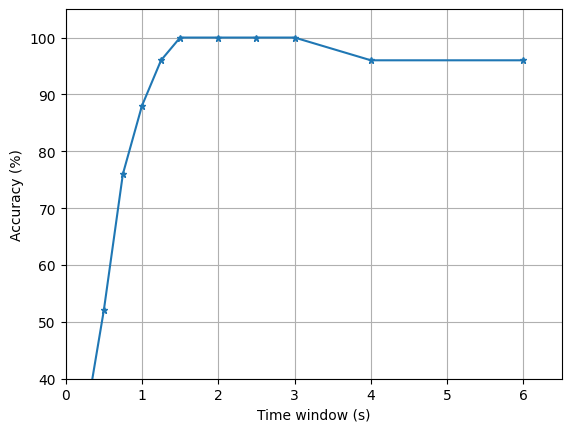

In [16]:
# print(accuracies)
fig, ax = plt.subplots()
ax.plot(t_win, accuracies, marker='*', markersize=5)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Time window (s)')
ax.set_xlim(0, 6.5)
ax.set_ylim(40, 105)
ax.grid(True)
plt.show()

1: Oz
2: POz
3: PO3
4: PO4
5: O1
6: O2
7: PO7
8: PO8

In [ ]:
# Time-frequency analysis
freqs = np.arange(1., 15., .3)
n_cycles = freqs

times = np.linspace(t_min, t_max, epochs.shape[2])

power_1 = mne.time_frequency.tfr_array_morlet(epochs[groundtruth == 0., :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles,
                                                output='avg_power')
power_2 = mne.time_frequency.tfr_array_morlet(epochs[groundtruth == 1., :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles,
                                                output='avg_power')

mne.baseline.rescale(power_1, times, (None, 0), mode='mean', copy=False)
mne.baseline.rescale(power_2, times, (None, 0), mode='mean', copy=False)
power = np.stack([power_1, power_2])

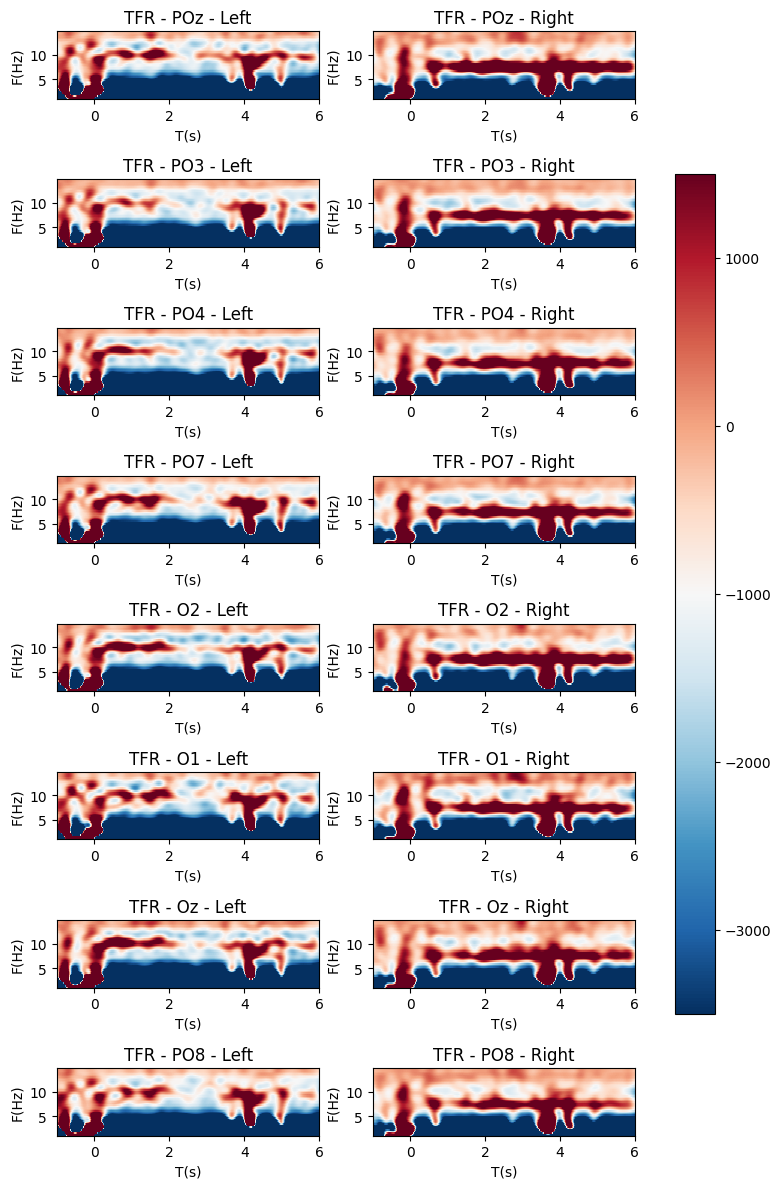

In [19]:

x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_chan, 2, figsize=(8, 12))
for j in range(2):
    for i in range(n_chan):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()

In [47]:
def psd_plot(filt_signal, chan_name, title='', fs=250, x_min=1, x_lim=30, y_lim = 125, line=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        f, psd = signal.welch(filt_signal[i], fs=fs, nperseg=fs, nfft=2*fs)
        ax.plot(f, psd, label='{}'.format(chan_name[i]))

    if line:
        ax.axvline(x=line, color='gray', linestyle='--')
        ax.text(line+0.2, 20, 'f = '+str(line)+'Hz', fontsize=12, color='gray')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.set_xlim(x_min, x_lim)
    ax.set_ylim(0, y_lim)
    ax.legend()
    ax.set_title('PSD ' + title)
    plt.tight_layout()
    plt.show()


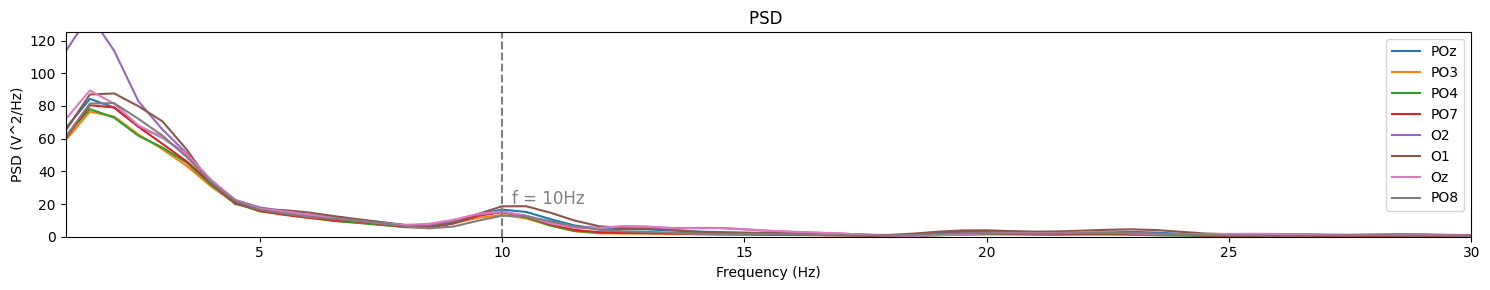

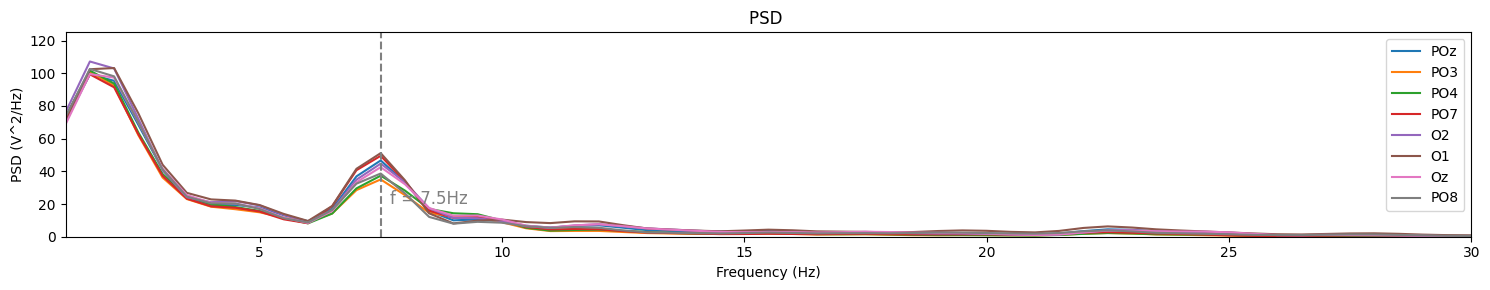

In [48]:
psd_plot(epochs[groundtruth == 0., :, :][0],chan_name, title = "", line=10)
psd_plot(epochs[groundtruth == 1., :, :][0],chan_name, title = "", line=7.5)